In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload
import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Plot the dataframe

from matplotlib.font_manager import FontProperties


In [ ]:
df_price = pd.read_feather('data/cmoney_price.feather')
df_price = ut.cmoney_data_clean_up(df_price)
df_price = df_price[['日期','股票代號','收盤價','成交量']].copy()
df_price.columns = ['date','ticker','unadj_price','volume']
df_price['date'] = pd.to_datetime(df_price['date'])
# sort by date for shift
df_price.sort_values(['ticker','date'],inplace=True)
# shift to get last day price
df_price['yesterday_price'] = df_price.groupby('ticker')['unadj_price'].shift(1)
df_price['unadj_price'] = df_price['unadj_price'].astype(float)
df_price['yesterday_price'] = df_price['yesterday_price'].astype(float)

# Rebalance

In [155]:
model_folder_name = '20230712_173216'
df_dividend_select = pd.read_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_top_50.feather')
df_portfolio = df_dividend_select[['ticker','date']].copy()

df_last_5d_volume = df_price[['ticker','date','unadj_price','volume']].copy()
df_last_5d_volume['volume'] = df_last_5d_volume['volume'].astype(float)
df_last_5d_volume.sort_values(['ticker','date'],inplace=True)
df_last_5d_volume.reset_index(drop=True,inplace=True)
df_last_5d_volume['rolling_5_d_sum'] = df_last_5d_volume.groupby('ticker', group_keys=False,as_index=False)['volume'].rolling(5).sum()['volume']

# merge the price to df_portfolio
df_portfolio = pd.merge(df_portfolio,df_last_5d_volume[['ticker','date','unadj_price','rolling_5_d_sum']],on=['ticker','date'],how='left')
df_portfolio['volume'] = df_portfolio['rolling_5_d_sum'].astype(float)
df_portfolio['volume_est'] = df_portfolio['rolling_5_d_sum'] * 0.2
df_portfolio['cap_amount'] = df_portfolio['volume_est'] * df_portfolio['unadj_price'] * 1000

# daily Redemption estimate
df_redemption_est = df_portfolio.groupby('date')['cap_amount'].mean().multiply(50).reset_index()
df_redemption_est.columns = ['date','mean']
# set the date as index
df_redemption_est.set_index('date',inplace=True)

# get the 25 percentile of the cap_amount
df_redemption_est['quantile_25'] = df_portfolio.groupby('date')['cap_amount'].quantile(0.25).values * 50
df_redemption_est['quantile_50'] = df_portfolio.groupby('date')['cap_amount'].quantile(0.50).values * 50

df_redemption_est[['mean','quantile_25','quantile_50']] = df_redemption_est[['mean','quantile_25','quantile_50']] / 100000000 / 0.3

In [255]:
df_redemption_est.describe()

,mean,quantile_25,quantile_50
count,72.0000,72.0000,72.0000
mean,344.5377,59.3999,164.7427
std,140.4608,31.9092,85.4560
min,138.3064,11.1433,32.8873
25%,230.7963,34.2664,105.3037
50%,328.8556,54.9595,134.6680
75%,415.2738,76.0456,210.4388
max,707.4863,185.8802,483.7621


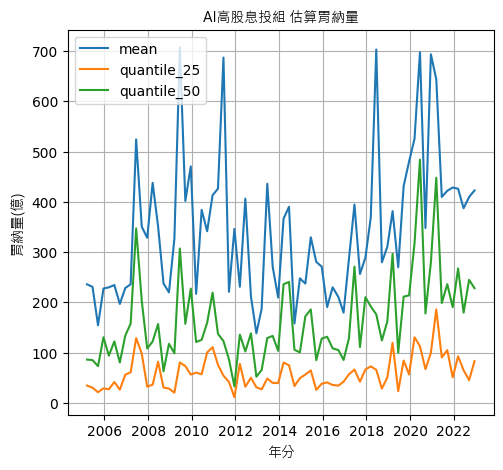

In [156]:
# Set the font properties
font = FontProperties(fname=r'C:\Windows\Fonts\msjh.ttc')  # Provide the path to your 微軟正黑體 font file

# Set the figure size
plt.figure(figsize=(5.5, 5))

plt.plot(df_redemption_est.index, df_redemption_est[['mean','quantile_25','quantile_50']], label = ['mean','quantile_25','quantile_50'])

# Adjust the y-axis tick labels
plt.ticklabel_format(style='plain', axis='y')  # Display full value on the y-axis

# Add labels and title to the plot
plt.xlabel('年分', fontproperties=font)
plt.ylabel('胃納量(億)', fontproperties=font)
plt.title('AI高股息投組 估算胃納量', fontproperties=font)
# set grid
plt.grid(True)

# show the legend
plt.legend()

# Show the plot
plt.show()

In [243]:
model_folder_name = '20230719_083148'
df_dividend_select_benchmark = pd.read_feather(f'./data/model/{model_folder_name}/df_select_pool_benchmark.feather')
df_portfolio = df_dividend_select_benchmark[['ticker','date']].copy()

df_last_5d_volume = df_price[['ticker','date','unadj_price','volume']].copy()
df_last_5d_volume['volume'] = df_last_5d_volume['volume'].astype(float)
df_last_5d_volume.sort_values(['ticker','date'],inplace=True)
df_last_5d_volume.reset_index(drop=True,inplace=True)
df_last_5d_volume['rolling_5_d_sum'] = df_last_5d_volume.groupby('ticker', group_keys=False,as_index=False)['volume'].rolling(5).sum()['volume']

# merge the price to df_portfolio
df_portfolio = pd.merge(df_portfolio,df_last_5d_volume[['ticker','date','unadj_price','rolling_5_d_sum']],on=['ticker','date'],how='left')
df_portfolio['volume'] = df_portfolio['rolling_5_d_sum'].astype(float)
df_portfolio['volume_est'] = df_portfolio['rolling_5_d_sum'] * 0.2
df_portfolio['cap_amount'] = df_portfolio['volume_est'] * df_portfolio['unadj_price'] * 1000

# daily Redemption estimate
df_redemption_est_benchmark = df_portfolio.groupby('date')['cap_amount'].mean().multiply(50).reset_index()
df_redemption_est_benchmark.columns = ['date','mean']
# set the date as index
df_redemption_est_benchmark.set_index('date',inplace=True)

# get the 25 percentile of the cap_amount
df_redemption_est_benchmark['quantile_25'] = df_portfolio.groupby('date')['cap_amount'].quantile(0.25).values * 50
df_redemption_est_benchmark['quantile_50'] = df_portfolio.groupby('date')['cap_amount'].quantile(0.50).values * 50

df_redemption_est_benchmark[['mean','quantile_25','quantile_50']] = df_redemption_est_benchmark[['mean','quantile_25','quantile_50']] / 100000000 / 0.3

In [256]:
df_redemption_est_benchmark.describe()

,mean,quantile_25,quantile_50
count,72.0000,72.0000,72.0000
mean,1768.8614,455.9406,861.9589
std,1086.1874,157.9295,317.2568
min,837.5806,141.3970,442.9038
25%,1208.1425,331.5266,627.1517
50%,1466.6825,434.4567,775.1048
75%,1819.1553,562.3041,1025.3284
max,6919.9158,942.4892,1843.5048


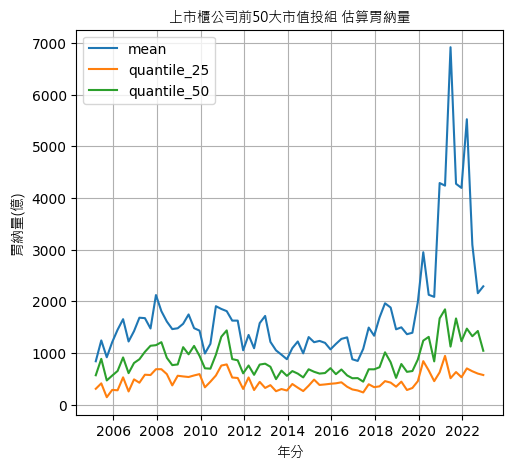

In [244]:
# Set the font properties
font = FontProperties(fname=r'C:\Windows\Fonts\msjh.ttc')  # Provide the path to your 微軟正黑體 font file
# Set the figure size
plt.figure(figsize=(5.5, 5))
plt.plot(df_redemption_est_benchmark.index, df_redemption_est_benchmark[['mean','quantile_25','quantile_50']], label = ['mean','quantile_25','quantile_50'])
# Adjust the y-axis tick labels
plt.ticklabel_format(style='plain', axis='y')  # Display full value on the y-axis
# Add labels and title to the plot
plt.xlabel('年分', fontproperties=font)
plt.ylabel('胃納量(億)', fontproperties=font)
plt.title('上市櫃公司前50大市值投組 估算胃納量', fontproperties=font)
plt.grid(True)
plt.legend()
plt.show()

In [245]:
df_redemption_est_ratio = df_redemption_est.merge(df_redemption_est_benchmark,how='left',left_index=True,right_index=True, suffixes=('_ai','_benchmark'))

In [258]:
df_redemption_est_ratio[['quantile_25_ratio']].describe()

,quantile_25_ratio
count,72.0000
mean,0.1319
std,0.0538
min,0.0369
25%,0.0960
50%,0.1291
75%,0.1615
max,0.2824


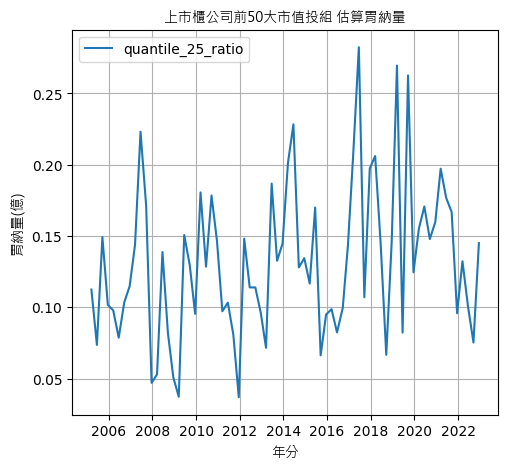

In [251]:
df_redemption_est_ratio['mean_ratio'] = df_redemption_est_ratio['mean_ai'] / df_redemption_est_ratio['mean_benchmark']
df_redemption_est_ratio['quantile_25_ratio'] = df_redemption_est_ratio['quantile_25_ai'] / df_redemption_est_ratio['quantile_25_benchmark']
df_redemption_est_ratio['quantile_50_ratio'] = df_redemption_est_ratio['quantile_50_ai'] / df_redemption_est_ratio['quantile_50_benchmark']


# Set the font properties
font = FontProperties(fname=r'C:\Windows\Fonts\msjh.ttc')  # Provide the path to your 微軟正黑體 font file
# Set the figure size
plt.figure(figsize=(5.5, 5))
plt.plot(df_redemption_est_ratio.index, df_redemption_est_ratio[['quantile_25_ratio']], label = 'quantile_25_ratio')
# Adjust the y-axis tick labels
plt.ticklabel_format(style='plain', axis='y')  # Display full value on the y-axis
# Add labels and title to the plot
plt.xlabel('年分', fontproperties=font)
plt.ylabel('胃納量(億)', fontproperties=font)
plt.title('上市櫃公司前50大市值投組 估算胃納量', fontproperties=font)
plt.grid(True)
plt.legend()
plt.show()

# Daily redemption and subscription

In [66]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

In [183]:
df_portfolio_daily = pd.merge(df_factor_all, df_dividend_select[['ticker','rebalance_date']], on=['ticker','rebalance_date'], how='right')[['date','ticker']].copy()

In [184]:
df_portfolio_daily = df_portfolio_daily.merge(df_price[['date','ticker','unadj_price','volume']],on=['date','ticker'],how='left')

In [185]:
df_portfolio_daily['volume'] = df_portfolio_daily['volume'].astype(float)
df_portfolio_daily['est_volume'] = df_portfolio_daily['volume'] * 0.2

In [186]:
df_portfolio_daily['cap_amount'] = df_portfolio_daily['est_volume'] * df_portfolio_daily['unadj_price'] * 1000

In [235]:
df_daily_est = df_portfolio_daily.groupby('date')['cap_amount'].mean().multiply(50).reset_index()
# set the date as index
df_daily_est.set_index('date',inplace=True)
df_daily_est.columns = ['mean']

# get the 25 percentile of the cap_amount
df_daily_est['quantile_25'] = df_portfolio_daily.groupby('date')['cap_amount'].quantile(0.25).values * 50
df_daily_est['quantile_50'] = df_portfolio_daily.groupby('date')['cap_amount'].quantile(0.50).values * 50

df_daily_est[['mean','quantile_25','quantile_50']] = df_daily_est[['mean','quantile_25','quantile_50']] / 100000000
df_daily_est['year'] = df_daily_est.index.year

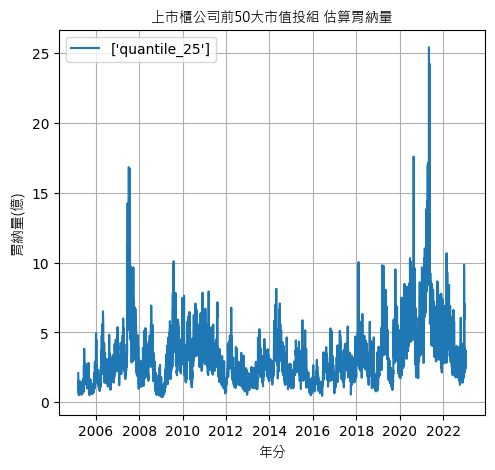

In [254]:
# Set the font properties
font = FontProperties(fname=r'C:\Windows\Fonts\msjh.ttc')  # Provide the path to your 微軟正黑體 font file
# Set the figure size
plt.figure(figsize=(5.5, 5))
plt.plot(df_daily_est.index, df_daily_est[['quantile_25']], label = ['quantile_25'])
# Adjust the y-axis tick labels
plt.ticklabel_format(style='plain', axis='y')  # Display full value on the y-axis
# Add labels and title to the plot
plt.xlabel('年分', fontproperties=font)
plt.ylabel('胃納量(億)', fontproperties=font)
plt.title('上市櫃公司前50大市值投組 估算胃納量', fontproperties=font)
plt.grid(True)
plt.legend()
plt.show()